In [1]:
import numpy as np
import itertools
import scipy.spatial as spspatial
import scipy.cluster.hierarchy as sch

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt


def fancy_dendrogram(*args, **kwargs):
    """
    plotting method from:
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


# Start with Random Data

(150, 2)


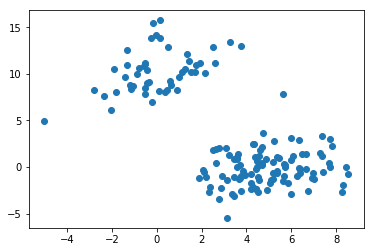

In [2]:
np.random.seed(42)  # for repeatability of this example
bigcluster1 = np.random.multivariate_normal([5.0, 0], [[3, 1], [1, 4]], size=[100,])
bigcluster2 = np.random.multivariate_normal([0, 10.0], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((bigcluster1, bigcluster2),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

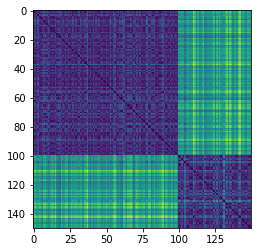

In [3]:
# which produces the distance matrix seen here

dists = spspatial.distance_matrix(X, X, p=2)

fig, ax = plt.subplots(1,1)

ax.imshow(dists)

plt.show()

# Now Perform Hierarchical Clustering

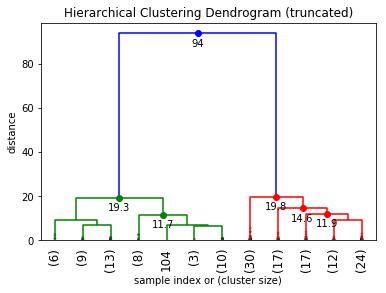

In [4]:
# ward
Z_ward = sch.linkage(X, 'ward')
c1 = Clustering().from_scipy_linkage(Z_ward, dist_rescaled = True)

fancy_dendrogram(
    Z_ward,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

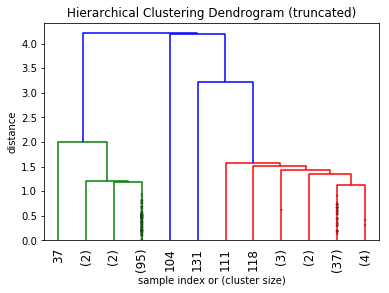

In [5]:
# single
Z_single = sch.linkage(X, 'single')
c2 = Clustering().from_scipy_linkage(Z_single, dist_rescaled = True)

fancy_dendrogram(
    Z_single,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

# Element-centric Similarity

In [6]:
# The element-centric similarity can take the full hierarchical clusterings

# Let's start with the single similarity value:
elsim = sim.element_sim(c1, c2, r=1.0, alpha=0.9)
print("Element-centric similarity: {}".format(elsim))

Element-centric similarity: 0.7539231751656281


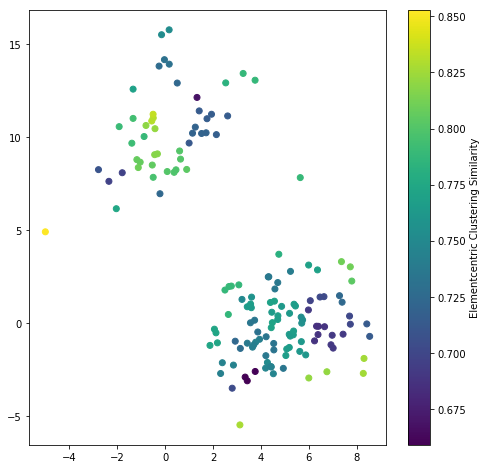

In [7]:
# The real advantages of the element-centric perspective come with understanding  
# which data-points are contributing to the differences

elementScores, relabeled_elements = sim.element_sim_elscore(c1, c2, r=1.0, alpha=0.9)
# elementScores gives a similarity value for each element (datapoint, node, etc.)

# relabeled_elements is a dict that maps elements to indexes of elementScore 
# --- this is important if your elements are not consisently named named 0,1,2, ..., n_elements-1
# as when you took a subset of the data and did not rename, or your elements are strings

# re-draw the picture
fig, ax = plt.subplots(1,1,figsize=(8,8))

# color now corresponds to the element-wise clustering similarity
# yellow is nearly perfect cluster assignment, 
# while purple denotes elements that are assigned to different clusters
#
# Note that the whole cluster changes color when a few elements are mis-assigned
# since it has changed that cluster 
plt.scatter(X[:,0], X[:,1], c = elementScores, cmap='viridis')
plt.colorbar(label='Elementcentric Clustering Similarity')
plt.show()